In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load packages

In [4]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [6]:
dataset = 'macosko2015'
dims = (50)
n_components = 64

In [7]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [8]:
import gzip
import pickle

with gzip.open(DATA_DIR / 'macosko_2015.pkl.gz', "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"].astype(str)

def zero_one_norm(x):
    return (x- np.min(x, axis=0))/ (np.max(x, axis=0)-np.min(x, axis=0))

x_norm = zero_one_norm(x)

print("Data set contains %d samples with %d features" % x.shape)

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x_norm, y, test_size=.1, random_state=42)

n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

X_train_flat = X_train
X_test_flat = X_test

from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

Y_train = enc.fit_transform([[i] for i in Y_train]).flatten()
Y_test = enc.fit_transform([[i] for i in Y_test]).flatten()

Data set contains 44808 samples with 50 features


### define networks

In [9]:
from tfumap.vae import VAE, Sampling

In [10]:
encoder_inputs = tf.keras.Input(shape=dims)
x = tf.keras.layers.Flatten()(encoder_inputs)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
z_mean = tf.keras.layers.Dense(n_components, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(n_components, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 50)           0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          5100        flatten[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
____________________________________________________________________________________________

In [11]:
latent_inputs = tf.keras.Input(shape=(n_components,))
x = tf.keras.layers.Dense(units=100, activation="relu")(latent_inputs)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
x = tf.keras.layers.Dense(units=100, activation="relu")(x)
decoder_outputs = tf.keras.layers.Dense(units=50, activation="sigmoid")(x)

decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()


Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               6500      
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
Total params: 31,750
Trainable params: 31,750
Non-trainable params: 0
_________________________________________________________________


### Create model and train

In [12]:
X_train.shape

(30327, 50)

In [13]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())

In [14]:
vae.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30
237/237 [==============================] - 1s 3ms/step - loss: 483.7693 - reconstruction_loss: 483.3413 - kl_loss: 0.4280
Epoch 2/30
237/237 [==============================] - 1s 3ms/step - loss: 480.0473 - reconstruction_loss: 479.6429 - kl_loss: 0.4045
Epoch 3/30
237/237 [==============================] - 1s 3ms/step - loss: 479.6017 - reconstruction_loss: 479.2876 - kl_loss: 0.3141
Epoch 4/30
237/237 [==============================] - 1s 4ms/step - loss: 479.4553 - reconstruction_loss: 479.1889 - kl_loss: 0.2663
Epoch 5/30
237/237 [==============================] - 1s 3ms/step - loss: 479.3266 - reconstruction_loss: 479.0886 - kl_loss: 0.2380
Epoch 6/30
237/237 [==============================] - 1s 4ms/step - loss: 479.1970 - reconstruction_loss: 478.9816 - kl_loss: 0.2154
Epoch 7/30
237/237 [==============================] - 1s 4ms/step - loss: 479.0506 - reconstruction_loss: 478.8543 - kl_loss: 0.1962
Epoch 8/30
237/237 [==============================] - 1s 4ms/step - l

In [15]:
# z = embedder.fit_transform(X_train_flat)

In [16]:
z = vae.encoder.predict(X_train)[0]

### Plot model output

In [17]:
Y_train

array([10.,  7.,  0., ..., 10.,  2., 10.])

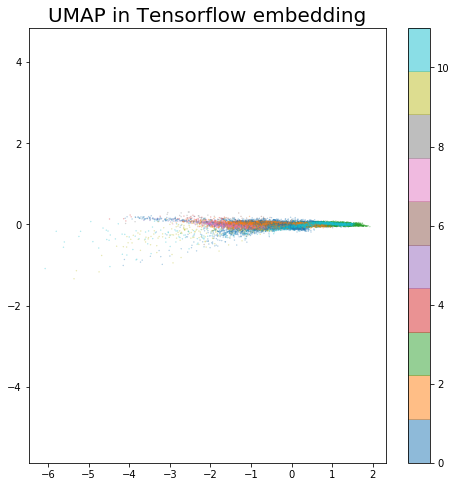

In [18]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)].flatten(),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [19]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

### Save output

In [59]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [60]:
output_dir = MODEL_DIR/'projections'/ dataset / '64'/ 'vae'
ensure_dir(output_dir)

In [61]:
#vae.save(output_dir)

In [62]:
vae.encoder.save(output_dir / 'encoder')

I0821 23:19:24.517724 139842244519744 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/vae/encoder/assets


In [63]:
vae.decoder.save(output_dir / 'encoder')

I0821 23:19:24.933554 139842244519744 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/macosko2015/64/vae/encoder/assets


In [64]:
#loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [65]:
np.save(output_dir / 'z.npy', z)

### compute metrics 

In [27]:
X_test.shape

(4481, 50)

In [28]:
z_test = encoder.predict(X_test.reshape((len(X_test), 50)))[0]

#### silhouette

In [29]:
from tfumap.silhouette import silhouette_score_block

In [30]:
ss, sil_samp = silhouette_score_block(z, Y_train, n_jobs = -1)
ss

0.3873419497697651

In [31]:
ss_test, sil_samp_test = silhouette_score_block(z_test, Y_test, n_jobs = -1)
ss_test

0.39415385039047773

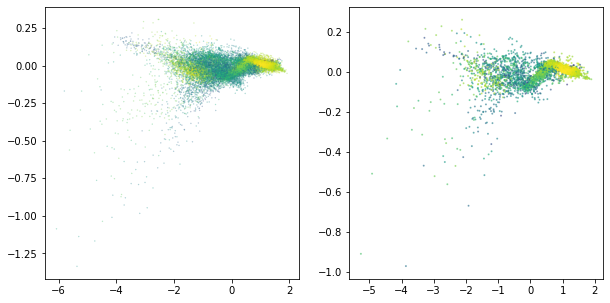

In [32]:
fig, axs = plt.subplots(ncols = 2, figsize=(10, 5))
axs[0].scatter(z[:, 0], z[:, 1], s=0.1, alpha=0.5, c=sil_samp, cmap=plt.cm.viridis)
axs[1].scatter(z_test[:, 0], z_test[:, 1], s=1, alpha=0.5, c=sil_samp_test, cmap=plt.cm.viridis)

#### KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier

In [34]:
neigh5 = KNeighborsClassifier(n_neighbors=5)
neigh5.fit(z, Y_train)
score_5nn = neigh5.score(z_test, Y_test)
score_5nn

0.9770140593617496

In [35]:
neigh1 = KNeighborsClassifier(n_neighbors=1)
neigh1.fit(z, Y_train)
score_1nn = neigh1.score(z_test, Y_test)
score_1nn

0.9669716581120286

#### Trustworthiness

In [36]:
from sklearn.manifold import trustworthiness

In [37]:
tw = trustworthiness(X_train_flat[:10000], z[:10000])

In [38]:
tw_test = trustworthiness(X_test_flat[:10000], z_test[:10000])

In [39]:
tw, tw_test

(0.9341802882305845, 0.9260655754308139)

### Save output metrics

In [40]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

#### train

In [41]:
metrics_df = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw, ss, sil_samp]
metrics_df

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
0,macosko2015,vae,64,0.93418,0.387342,"[0.36883589228294705, 0.4076033567200585, -0.0..."


In [42]:
save_loc = DATA_DIR / 'projection_metrics' /  'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### test

In [43]:
metrics_df_test = pd.DataFrame(
    columns=[
        "dataset",
        "class_",
        "dim",
        "trustworthiness",
        "silhouette_score",
        "silhouette_samples",
    ]
)
metrics_df_test.loc[len(metrics_df)] = [dataset, 'vae', n_components, tw_test, ss_test, sil_samp_test]
metrics_df_test

,dataset,class_,dim,trustworthiness,silhouette_score,silhouette_samples
1,macosko2015,vae,64,0.926066,0.394154,"[0.4816070376470057, -0.012686150953653592, 0...."


In [44]:
save_loc = DATA_DIR / 'projection_metrics' / 'vae' / 'test' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
metrics_df.to_pickle(save_loc)

#### knn 

In [45]:
nn_acc_df = pd.DataFrame(columns = ["method_","dimensions","dataset","1NN_acc","5NN_acc"])
nn_acc_df.loc[len(nn_acc_df)] = ['vae', n_components, dataset,  score_1nn, score_5nn]
nn_acc_df

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,vae,64,macosko2015,0.966972,0.977014


In [46]:
save_loc = DATA_DIR / 'knn_classifier' / 'vae' / 'train' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
nn_acc_df.to_pickle(save_loc)

### Reconstruction

In [47]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score

In [48]:
X_recon = vae.decoder.predict(vae.encoder.predict(X_test.reshape((len(X_test), 50)))[0])
X_real = X_test.reshape((len(X_test), 50))

In [49]:
x_real = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
x_recon = X_recon.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

In [50]:
reconstruction_acc_df = pd.DataFrame(
    columns=["method_", "dimensions", "dataset", "MSE", "MAE", "MedAE", "R2"]
)

In [57]:
MSE = mean_squared_error(
    x_real, 
    x_recon
)
MAE = mean_absolute_error(
    x_real, 
    x_recon
)
MedAE = median_absolute_error(
    x_real, 
    x_recon
)
R2 = r2_score(
    x_real, 
    x_recon
)

reconstruction_acc_df.loc[len(reconstruction_acc_df)] = ['vae', 64, dataset, MSE, MAE, MedAE, R2]
reconstruction_acc_df

,method_,dimensions,dataset,MSE,MAE,MedAE,R2
0,vae,2,macosko2015,0.000345,0.009504,0.005681,0.509231
1,vae,64,macosko2015,0.000345,0.009504,0.005681,0.509231


In [58]:
save_loc = DATA_DIR / 'reconstruction_acc' / 'vae' / str(n_components) / (dataset + '.pickle')
ensure_dir(save_loc)
reconstruction_acc_df.to_pickle(save_loc)

### Compute clustering quality

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

In [54]:
def get_cluster_metrics(row, n_init=5):
    
    # load cluster information
    save_loc = DATA_DIR / 'clustering_metric_df'/ ('_'.join([row.class_, str(row.dim), row.dataset]) + '.pickle')
    print(save_loc)
    if save_loc.exists() and save_loc.is_file():
        
        cluster_df = pd.read_pickle(save_loc)
        return cluster_df
    
    # make cluster metric dataframe
    cluster_df = pd.DataFrame(
        columns=[
            "dataset",
            "class_",
            "dim",
            "silhouette",
            "homogeneity",
            "completeness",
            "v_measure",
            "init_",
            "n_clusters",
            "model",
        ]
    )
    y = row.train_label
    z = row.train_z
    n_labels = len(np.unique(y))
    for n_clusters in tqdm(np.arange(n_labels - int(n_labels / 2), n_labels + int(n_labels / 2)), leave=False, desc = 'n_clusters'):
        for init_ in tqdm(range(n_init), leave=False, desc='init'):
            kmeans = KMeans(n_clusters=n_clusters, random_state=init_).fit(z)
            clustered_y = kmeans.labels_
            homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(
                y, clustered_y
            )
            ss, _ = silhouette_score_block(z, clustered_y)
            cluster_df.loc[len(cluster_df)] = [
                row.dataset,
                row.class_,
                row.dim,
                ss,
                homogeneity,
                completeness,
                v_measure,
                init_,
                n_clusters,
                kmeans,
            ]
    
     # save cluster df in case this fails somewhere
    ensure_dir(save_loc)
    cluster_df.to_pickle(save_loc)
    return cluster_df

In [55]:
projection_df = pd.DataFrame(columns = ['dataset', 'class_', 'train_z', 'train_label', 'dim'])
projection_df.loc[len(projection_df)] = [dataset, 'vae', z, Y_train.flatten(), n_components]
projection_df

,dataset,class_,train_z,train_label,dim
0,macosko2015,vae,"[[0.5538558, 0.018479256, 0.021293806, -0.0171...","[10.0, 7.0, 0.0, 10.0, 10.0, 10.0, 10.0, 10.0,...",64


In [56]:
get_cluster_metrics(projection_df.iloc[0], n_init=5)

/mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/data/clustering_metric_df/vae_64_macosko2015.pickle


,dataset,class_,dim,silhouette,homogeneity,completeness,v_measure,init_,n_clusters,model
0,macosko2015,vae,64,0.390035,0.587057,0.472790,0.523764,0,6,"KMeans(n_clusters=6, random_state=0)"
1,macosko2015,vae,64,0.389497,0.587596,0.472759,0.523959,1,6,"KMeans(n_clusters=6, random_state=1)"
2,macosko2015,vae,64,0.389506,0.587643,0.472806,0.524007,2,6,"KMeans(n_clusters=6, random_state=2)"
3,macosko2015,vae,64,0.388968,0.587770,0.472546,0.523898,3,6,"KMeans(n_clusters=6, random_state=3)"
4,macosko2015,vae,64,0.389825,0.587017,0.472625,0.523646,4,6,"KMeans(n_clusters=6, random_state=4)"
5,macosko2015,vae,64,0.396504,0.592107,0.450001,0.511365,0,7,"KMeans(n_clusters=7, random_state=0)"
6,macosko2015,vae,64,0.396120,0.597148,0.452519,0.514870,1,7,"KMeans(n_clusters=7, random_state=1)"
7,macosko2015,vae,64,0.396689,0.591907,0.450051,0.511322,2,7,"KMeans(n_clusters=7, random_state=2)"
8,macosko2015,vae,64,0.396659,0.591958,0.450060,0.511347,3,7,"KMeans(n_clusters=7, random_state=3)"
9,macosko2015,vae,64,0.396689,0.591907,0.450051,0.511322,4,7,"KMeans(n_clusters=7, random_state=4)"
